In [200]:
from functools import partial
from typing import Callable

import arviz
import jax
import jax.numpy as jnp
import scipy.optimize as opt
import jax.scipy.stats as jstats
import matplotlib.pyplot as plt
import numpyro
import pandas as pd
import seaborn as sns
from numpyro import distributions as dist
from sklearn.model_selection import train_test_split
from tqdm.auto import tqdm
import warnings

In [2]:
@jax.jit
def g(x):
    return -(jnp.sin(6 * jnp.pi * x) ** 2) + 6 * x**2 - 5 * x**4 + 3 / 2


g(1)

Array(2.5, dtype=float32, weak_type=True)

In [170]:
dataset_t = tuple[
    jnp.ndarray, jnp.ndarray, jnp.ndarray, jnp.ndarray, jnp.ndarray, jnp.ndarray
]


# Training set to condition the kernel on, validation set to tune hyperparameters
# / calculate likelihood for mcmc, test set to compare models with
@partial(jax.jit, static_argnums=(0,))
def generate_dataset(number_of_obs=30, key: jnp.ndarray = None) -> dataset_t:
    if key is None:
        key = jax.random.key(0)
    x_data = jnp.linspace(0, 1, number_of_obs)
    y_data = g(x_data) + jax.random.normal(key, x_data.shape) * 0.01
    x_train_valid, x_test, y_train_valid, y_test = train_test_split(
        x_data, y_data, train_size=number_of_obs // 3 * 2, random_state=42
    )
    x_train, x_valid, y_train, y_valid = train_test_split(
        x_train_valid, y_train_valid, train_size=0.6, random_state=42
    )
    return x_train, y_train, x_valid, y_valid, x_test, y_test


generate_dataset(30)

(Array([0.6551724 , 0.3448276 , 1.        , 0.1724138 , 0.10344827,
        0.20689654, 0.37931034, 0.62068963, 0.06896552, 0.7241379 ,
        0.6896552 , 0.03448276], dtype=float32),
 Array([3.0942016 , 2.0757453 , 2.4888556 , 1.6713592 , 0.7148039 ,
        1.2704791 , 1.6844136 , 2.490983  , 0.58994573, 2.4922152 ,
        3.040235  , 1.1502597 ], dtype=float32),
 Array([0.13793103, 0.4827586 , 0.2413793 , 0.55172414, 0.86206895,
        0.7586207 , 0.8965517 , 0.44827586], dtype=float32),
 Array([1.3570876, 2.5320344, 0.8686456, 2.1747959, 2.9203305, 2.3315835,
        2.223386 , 1.8244766], dtype=float32),
 Array([0.9310345 , 0.51724136, 0.79310346, 0.5862069 , 0.27586207,
        0.31034482, 0.9655172 , 0.8275862 , 0.4137931 , 0.        ],      dtype=float32),
 Array([2.0140355, 2.6466045, 2.811917 , 1.9905599, 1.1414744, 1.855348 ,
        2.37807  , 3.241496 , 1.3928322, 1.4971629], dtype=float32))

In [30]:
# Params (6): [Variance periodic, Length-scale periodic, Period, Variance rational, Mixture scale rational]


@partial(jnp.vectorize, signature="(x),(z),(4)->(x,z)")
@jax.jit
def rational_quadratic(x: jnp.ndarray, z: jnp.ndarray, params: jnp.ndarray):
    assert params.shape == (6,)
    variance, length_scale, mixture_scale = params[0], params[1], params[3]
    return variance * (
        1
        + 0.5
        * (x.reshape((-1, 1)) - z.reshape((1, -1))) ** 2
        / (mixture_scale * length_scale**2)
    ) ** (-mixture_scale)


ex_x = jnp.linspace(0, 1, num=3)
ex_params = jnp.array([[1, 1, 0.2, 2], [1, 1, 5, 0.5]])
rational_quadratic(ex_x, ex_x, ex_params)

Array([[[2.        , 1.7777778 , 1.3333334 ],
        [1.7777778 , 2.        , 1.7777778 ],
        [1.3333334 , 1.7777778 , 2.        ]],

       [[0.5       , 0.4848485 , 0.44444445],
        [0.4848485 , 0.5       , 0.4848485 ],
        [0.44444445, 0.4848485 , 0.5       ]]], dtype=float32)

In [31]:
@partial(jnp.vectorize, signature="(x),(z),(4)->(x,z)")
@jax.jit
def periodic_kernel(x: jnp.ndarray, z: jnp.ndarray, params: jnp.ndarray):
    variance, length_scale, period = params[0], params[1], params[2]
    return variance * jnp.exp(
        -2
        * jnp.sin(jnp.pi * (x.reshape((-1, 1)) - z.reshape((1, -1))) / period) ** 2
        / length_scale**2
    )


periodic_kernel(ex_x, ex_x, ex_params)

Array([[[1.        , 0.13533528, 1.        ],
        [0.13533528, 1.        , 0.13533528],
        [1.        , 0.13533528, 1.        ]],

       [[1.        , 0.8261466 , 0.50108325],
        [0.8261466 , 1.        , 0.8261466 ],
        [0.50108325, 0.8261466 , 1.        ]]], dtype=float32)

In [32]:
@partial(jnp.vectorize, signature="(x),(z),(6)->(x,z)")
@jax.jit
def total_kernel(x: jnp.ndarray, z: jnp.ndarray, params: jnp.ndarray):
    return rational_quadratic(x, z, params) + periodic_kernel(x, z, params)


total_kernel(ex_x, ex_x, ex_params)

Array([[[3.       , 1.9131131, 2.3333335],
        [1.9131131, 3.       , 1.9131131],
        [2.3333335, 1.9131131, 3.       ]],

       [[1.5      , 1.3109951, 0.9455277],
        [1.3109951, 1.5      , 1.3109951],
        [0.9455277, 1.3109951, 1.5      ]]], dtype=float32)

In [59]:
@partial(jnp.vectorize, signature="(x),(z),(2)->(x,z)")
@jax.jit
def wavy_kernel(x: jnp.ndarray, y: jnp.ndarray, params: jnp.ndarray):
    a, b = params[0], params[1]
    return (1 + x.reshape((-1, 1)) @ y.reshape((1, -1))) ** 2 + a * (
        jnp.sin(2 * jnp.pi * x.flatten() + b).reshape((-1, 1))
        * jnp.sin(2 * jnp.pi * y.flatten() + b).reshape((1, -1))
    )


wavy_kernel(ex_x, ex_x, jnp.array([1, 1]))

Array([[1.7080734, 0.2919265, 1.7080735],
       [0.2919265, 2.2705736, 1.5419264],
       [1.7080735, 1.5419264, 4.7080736]], dtype=float32)

In [179]:
@jax.jit
def parameter_prior_wavy(noise_params: jnp.ndarray):
    noise_y, a, b = noise_params[0], noise_params[1], noise_params[2]
    return (
        jstats.expon.logpdf(noise_y)
        + jstats.expon.logpdf(a)
        + jstats.uniform.logpdf(b, loc=0, scale=2 * jnp.pi)
    )

In [180]:
kernel = wavy_kernel
num_kernel_params = 2
ex_params = jnp.array([1, 1])
parameter_prior = parameter_prior_wavy

In [64]:
@partial(jnp.vectorize, signature=f"(t),(t),(s),(),({num_kernel_params})->(s),(s,s)")
@jax.jit
def posterior_conditional(
    x_train: jnp.ndarray,
    y_train: jnp.ndarray,
    x_star: jnp.ndarray,
    noise_y: float,
    params: jnp.ndarray,
):
    inverse_cov = jnp.linalg.inv(
        kernel(x_train, x_train, params) + noise_y * jnp.identity(len(x_train))
    )
    kernel_star = kernel(x_train, x_star, params)
    mu_star = kernel_star.T @ inverse_cov @ y_train
    cov_star = (
        kernel(x_star, x_star, params) - kernel_star.T @ inverse_cov @ kernel_star
    )
    return mu_star, cov_star


posterior_conditional(ex_x, ex_x, ex_x[:2], 0.1, ex_params)

(Array([0.02836096, 0.4943103 ], dtype=float32),
 Array([[ 0.09142661, -0.00116915],
        [-0.0011692 ,  0.09450984]], dtype=float32))

In [181]:
@partial(jax.jit, static_argnames=("use_test_set",))
def log_posterior_prob(
    noise_params: jnp.ndarray, dataset: dataset_t, use_test_set: bool = False
):
    if use_test_set:
        x_train, y_train, _x_valid, _y_valid, x_star, y_star = dataset
    else:
        x_train, y_train, x_star, y_star, _x_test, _y_test = dataset

    noise_y, params = noise_params[0], noise_params[1:]
    mu_star, cov_star = posterior_conditional(x_train, y_train, x_star, noise_y, params)
    cov = cov_star + noise_y * jnp.identity(len(mu_star))
    logpdf = jstats.multivariate_normal.logpdf(y_star, mean=mu_star, cov=cov)
    prior = parameter_prior(noise_params)
    return jnp.nan_to_num(logpdf + prior, nan=-jnp.inf)


ex_full_params = jnp.concat((jnp.array([0.1]), ex_params), axis=0)
log_posterior_prob(ex_full_params, generate_dataset(30))

Array(-6.774468, dtype=float32)

In [154]:
def grid_search(
    search_ranges: tuple[tuple[float, float], ...], grid_size: int, dataset: dataset_t
):
    opt_params = opt.brute(
        lambda p: -log_posterior_prob(p, dataset),
        search_ranges,
        Ns=grid_size,
        finish=None,
    )
    return opt_params

In [156]:
ex_dataset = generate_dataset()

In [182]:
found_params = grid_search(
    search_ranges=((1.0e-2, 10), (0, 2), (0, 2 * jnp.pi)),
    grid_size=50,
    dataset=ex_dataset,
)
found_params

array([0.21387755, 0.08163265, 0.64114136])

In [183]:
log_posterior_prob(found_params, ex_dataset, use_test_set=True)

Array(-8.646334, dtype=float32)

In [184]:
class KernelProbDensity(dist.Distribution):
    support = dist.constraints.interval(-3, 3)
    arg_constraints = {"start": support}  # noqa: RUF012

    def __init__(self, dataset: dataset_t, start: jnp.ndarray = None):
        if start is None:
            start = ex_full_params
        assert start.shape == (num_kernel_params + 1,), start.shape
        self.start = start
        self.dataset = dataset
        super().__init__(event_shape=(num_kernel_params + 1,))

    def sample(self, _key, sample_shape=()):
        return jnp.full(sample_shape, self.start)

    def log_prob(self, value):
        assert value.shape == (
            num_kernel_params + 1,
        ), f"{value.shape=} {(num_kernel_params + 1)=}"
        return log_posterior_prob(value, self.dataset)

In [185]:
def mcmc_kernel_model(dataset: dataset_t):
    return numpyro.sample("noise_params", KernelProbDensity(dataset))

In [201]:
warnings.filterwarnings("ignore", message="There are not enough devices to run parallel chains")

In [202]:
nuts_kernel = numpyro.infer.NUTS(mcmc_kernel_model)
ex_mcmc = numpyro.infer.MCMC(
    nuts_kernel, num_samples=3_000, num_chains=8, num_warmup=2000, progress_bar=True
)
ex_mcmc.run(jax.random.key(1), ex_dataset)

sample: 100%|██████████| 5000/5000 [00:01<00:00, 3949.83it/s, 9 steps of size 7.11e-02. acc. prob=0.85]  


<Axes: ylabel='Count'>

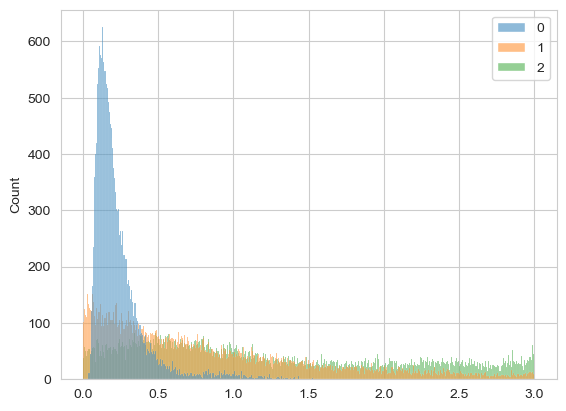

In [196]:
samples: jnp.ndarray = ex_mcmc.get_samples()["noise_params"]
sns.histplot(samples, binwidth=0.005)

In [195]:
arv = arviz.from_dict(ex_mcmc.get_samples(group_by_chain=True))
summ = arviz.summary(arv)
summ.index = ["y noise", "a", "b"]
summ

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
y noise,0.235,0.185,0.048,0.529,0.017,0.014,374.0,102.0,1.02
a,0.828,0.713,0.000,2.254,0.021,0.016,1315.0,1164.0,1.00
b,1.232,0.861,0.001,2.768,0.034,0.026,689.0,669.0,1.01


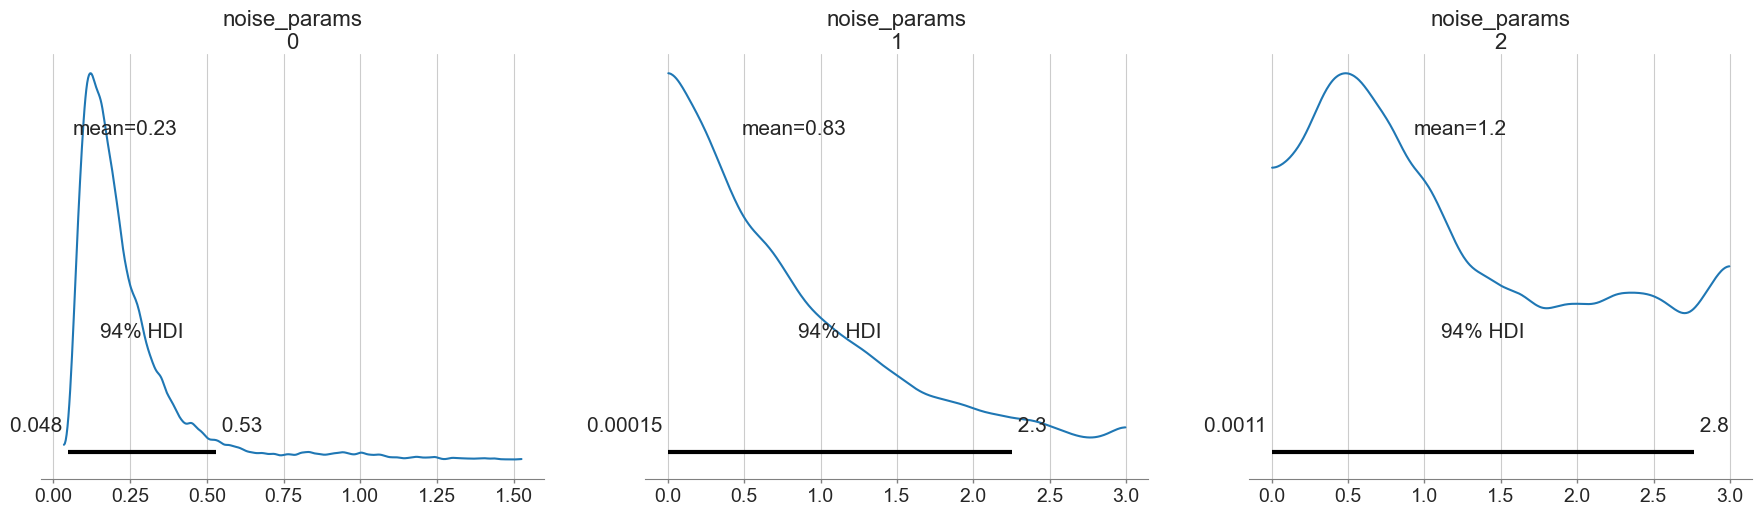

In [197]:
arviz.plot_posterior(arv)
plt.show()

In [198]:
ex_strided_post_samples = ex_mcmc.get_samples(group_by_chain=True)[
    "noise_params"
].reshape((-1, 3))[::8 * 6]
ex_strided_post_samples.shape

(500, 3)

In [199]:
def approx_posterior(posterior_samples: jnp.ndarray, dataset: dataset_t):
    def calc_likelihood(_, post_sample: jnp.ndarray):
        return (), log_posterior_prob(post_sample, dataset, use_test_set=True)

    return jax.lax.scan(calc_likelihood, (), posterior_samples)[1]


approx_posterior(ex_strided_post_samples, generate_dataset()).mean()

Array(-11.021283, dtype=float32)

In [203]:
def repeat_estimate(key: jnp.ndarray = None, n_times: int = 20, n_obs: int = 30):
    if key is None:
        key = jax.random.key(42)

    map_likelihoods = []
    mcmc_likelihoods = []

    for iter_key in tqdm(jax.random.split(key, n_times), desc="Repeated estimation"):
        data_key, mcmc_key = jax.random.split(iter_key)
        dataset = generate_dataset(number_of_obs=n_obs, key=data_key)
        map_params = grid_search(
            search_ranges=((1.0e-2, 10), (-1, 1), (0, 2 * jnp.pi)),
            grid_size=75,
            dataset=ex_dataset,
        )
        map_likelihoods.append(
            log_posterior_prob(map_params, dataset, use_test_set=True)
        )

        mcmc = numpyro.infer.MCMC(
            nuts_kernel,
            num_samples=3_000,
            num_chains=8,
            num_warmup=2_000,
            progress_bar=False,
        )
        mcmc.run(mcmc_key, dataset)
        strided_samples = mcmc.get_samples(group_by_chain=True)["noise_params"].reshape(
            (-1, 3)
        )[::8 * 6]
        mcmc_likelihoods.append(
            approx_posterior(strided_samples, generate_dataset()).mean()
        )

    return jnp.array(map_likelihoods), jnp.array(mcmc_likelihoods)

In [204]:
map_ls, mcmc_ls = repeat_estimate()

Repeated estimation:   0%|          | 0/20 [00:00<?, ?it/s]

In [208]:
map_ls, map_ls.mean()

(Array([-8.793975 , -8.813328 , -8.816643 , -8.683634 , -8.617303 ,
        -8.733367 , -8.924727 , -8.756771 , -8.803385 , -8.78731  ,
        -9.004909 , -8.718636 , -8.759394 , -8.77553  , -8.814344 ,
        -8.888703 , -9.006361 , -8.712639 , -8.7121935, -8.876108 ],      dtype=float32),
 Array(-8.799964, dtype=float32))

In [209]:
mcmc_ls, mcmc_ls.mean()

(Array([-10.9755945, -10.901855 , -10.977362 , -10.950463 , -10.978203 ,
        -11.0044   , -10.998256 , -11.013045 , -10.938569 , -11.113309 ,
        -10.900817 , -11.172851 , -10.939088 , -10.956308 , -11.071995 ,
        -10.890988 , -10.695964 , -11.04382  , -10.979169 , -10.899643 ],      dtype=float32),
 Array(-10.970085, dtype=float32))